### Carbon stock determination of a droughted Pinon-Juniper woodland using structure from motion
##### Dan J. Krofcheck, Christopher Lippitt, Marcy E. Litvak (Jesse and Su and ...?)
Low cost photogrammetry projects from either manned or unmanned aircraft can leverage high image overlap to produce 3-dimensional point clouds of surface features, interpolate ground terrain, and gain some crude multi-spectral capabilities such as pseudo-NDVI with the use of makeshift filters. 

Here we test the ability of SfM data to characterize the distribution of C stocks across a PJ woodland, and subsequently bin the biomass estimates into live and dead carbon pools.

Analysis requirements:
    1. Use ground measurements and allometries to create a volume to biomass 
        relationship for P and J
    2. Perturb this relationship for varying degrees of P mortality
    3. Characterize the SfM to ground volume uncertainty
    4. propagate uncertainty from P mortality and volume:volume 
        relationship into SfM volume to ground biomass relationship
    5. Conduct a segmentation on the SfM data
    6. Determine vegetation status (live / dead) using pseudo NDVI for each segment
    7. Apply allometry to each segment, if segment is dead, subtract foliar biomass 
        component

#### Load required libraries

In [26]:
# ------- Notebook config
%matplotlib inline
import matplotlib.colors
import matplotlib.pyplot as plt

# ------- Load dependencies
import pandas as pd
import numpy as np
import seaborn as sns
import os, osr, gdal
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.regression.quantile_regression import QuantReg
from statsmodels.sandbox.regression.predstd import wls_prediction_std

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.regression.quantile_regression import QuantReg
from statsmodels.sandbox.regression.predstd import wls_prediction_std

# Data Input Dir
dataIn = 'Y:/DanK/DeerCanyon/Analysis_get/'
# Output Dir:
dataOut ='Y:/DanK/DeerCanyon/Analysis_put/'


#### Function definition

In [1]:
# IO
def importRaster(rasterPath, **kwargs):
    # Open and read in the raster as an array
    raster_ds = gdal.Open(rasterPath)
    rastermap = raster_ds.ReadAsArray()
    
    # Set the default data type to 'float'
    if 'dtype' not in kwargs:
        dtype = 'float'
    rastermap = rastermap.astype(dtype)
    
    # If specified, set the no data value to NaN
    if 'noData' in kwargs:
        rastermap[rastermap == noData] = np.nan
    return rastermap

# Ground data plots -- curve fit process
def linearFit(x, yparams, **kwargs):
    return coeffs, rmse, resid

def plotFit(x, coefs, confInt):
    return plot

def dropData(x, yparams, **kwargs):
    return subsetOfData

# Segmentation classification
def defineStatus(segmentation, attributes, fourBandRaster):
    return ndviRaster, liveDeadRaster, attributesModified

# Biomass designation
def calculteBiomass(segmentation, attributesModified, liveDeadRaster):
    return biomassRaster 

# Raster visualization
def plotRaster(image, ax=None, *args, **kwargs):

    # Grab figure axes if none stated
    if ax == None:
         ax = plt.gca()
                   
    # Normalize color scheme
    if 'norm' not in kwargs:
        vmin = kwargs.pop('vmin', None)
        vmax = kwargs.pop('vmax', None)
        if vmin is None:
            vmin = np.min(image) # or what ever
        if vmax is None:
            vmax = np.max(image)
        norm = matplotlib.colors.Normalize(vmin, vmax)
        kwargs['norm'] = norm

    #ax.figure.canvas.draw() # if you want to force a re-draw
    ax.imshow(image, *args, **kwargs)
    # Setup axes
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])

# Vector visualization

### Linear regression of the ground data
The conceptual framework is contingent on there being a strong, species invarient relationship between crown volume and crown biomass. This plot data at the very least represents one approximation of that relationship. By fitting biomass to volume alone, we're leveraging the least amount of information possible. Given that these data were collected with height sticks and DBH  tapes, I'd say its a pretty decent relationship.

In [60]:
plotData = pd.read_csv(dataIn + 'CPLOT_BIOMASS.csv')
plotData = plotData[plotData.Year == 2013]
pinon = plotData[plotData.Species == 'PIED ']
jumo = plotData[plotData.Species == 'JUMO']

fitData = pd.DataFrame(dict(SPECIES = plotData['Species'],
                            PLOT = plotData['Transect'],
                            VOLUME = plotData['Volume (m3)'],
                            BIOMASS = plotData['BIOMASS']/1000))

ols = smf.ols('BIOMASS ~ VOLUME', fitData).fit()
slope = (ols.params['VOLUME'])
intercept = (ols.params['Intercept'])

ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                BIOMASS   R-squared:                       0.744
Model:                            OLS   Adj. R-squared:                  0.743
Method:                 Least Squares   F-statistic:                     1294.
Date:                Mon, 25 Sep 2017   Prob (F-statistic):          6.34e-134
Time:                        14:58:09   Log-Likelihood:                -1893.9
No. Observations:                 448   AIC:                             3792.
Df Residuals:                     446   BIC:                             3800.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      1.7009      0.981      1.735      0.083        -0.226     3.628
VOLUME         1.2905      0.036     35.972      0.000         1.220     1.361
==============================================================================
Omnibus:                      214.705   Durbin-Watson:                   1.975
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3260.905
Skew:                           1.660   Prob(JB):                         0.00
Kurtosis:                      15.793   Cond. No.                         34.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

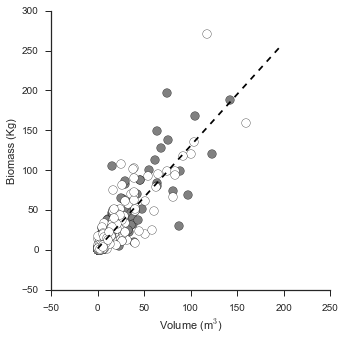

In [66]:
f, (ax) = plt.subplots(1,1, figsize = (5,5))
sns.set_style('ticks')
sns.despine()
spcCol = ['gray','white']
idx = 0
y = []

for num in np.arange(0, 200, 1):
     y.append(intercept + slope*num)
ax.plot(np.arange(0, 200, 1), y, color = 'black', linestyle = '--')

for species in fitData.SPECIES.unique():
    toPlot = fitData[fitData.SPECIES == species]
    ax.scatter(toPlot.VOLUME, toPlot.BIOMASS, 
                color = spcCol[idx], marker = 'o',  
                edgecolor='k', s = 75)
    idx += 1
    
ax.set_ylabel('Biomass (Kg)')
ax.set_xlabel('Volume (m$^{3}$)')